<a href="https://colab.research.google.com/github/sashajoanna/sjw/blob/master/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
# import Python libraries
import os #provides functions for interacting with the operating system
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss, f1_score, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

from math import sqrt

%matplotlib inline

In [ ]:
# Get the data from BQ table
%%bigquery df --project datalake-datamarts-production

SELECT
claimed, 
category,
description,
impressions
FROM business_intelligence.sjw_has_review_impressions_yn

Could not save output to variable 'df'.

ERROR:
 ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Google Compute Engine metadata service. Status: 404 Response:\nb''", <google.auth.transport.requests._Response object at 0x7f4f95d5b460>)


# Cleaning data: removing NULLs

In [ ]:
df.isnull().sum()


claimed         0
category        0
description    10
impressions     0
dtype: int64

In [ ]:
df[df['description'].isnull()]


,claimed,category,description,impressions
643166,1,1,<NA>,0
643167,1,1,<NA>,0
643168,1,1,<NA>,0
643169,0,0,<NA>,0
643170,0,1,<NA>,0
643171,1,0,<NA>,0
643172,1,1,<NA>,1
643173,1,1,<NA>,1
643174,1,1,<NA>,1
643175,1,0,<NA>,1


In [ ]:
# Deleting the NULL values
df = df.dropna(subset = ['description'])

# Printing the shape
print(df.shape)

# Visualize the NULL observations
df.isnull().sum()

(643166, 4)


claimed        0
category       0
description    0
impressions    0
dtype: int64

# Investigating the data

In [ ]:
# Investigate all the elements whithin each Feature 

for column in df:
    unique_values = np.unique(df[column])
    nr_values = len(unique_values)
    if nr_values <= 10:
        print("The number of values for feature {} is: {} -- {}".format(column, nr_values, unique_values))
    else:
        print("The number of values for feature {} is: {}".format(column, nr_values))

The number of values for feature claimed is: 2 -- [0 1]
The number of values for feature category is: 2 -- [0 1]
The number of values for feature description is: 2 -- [0 1]
The number of values for feature impressions is: 2 -- [0 1]


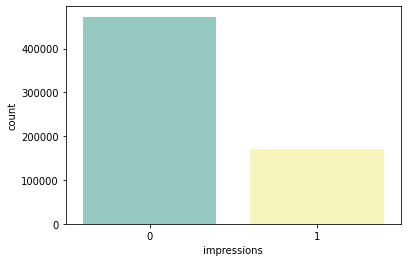

In [ ]:
# Investigating the distr of y

sns.countplot(x = 'impressions', data = df, palette = 'Set3')

In [ ]:
df.columns


Index(['claimed', 'category', 'description', 'impressions'], dtype='object')

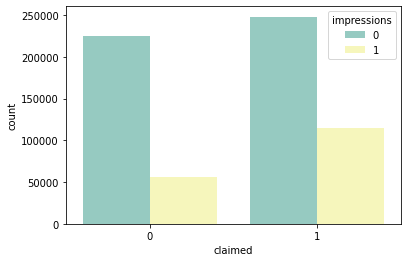

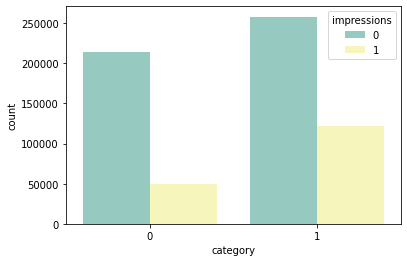

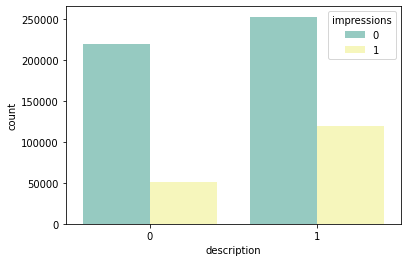

In [ ]:
# Looping through all the features by our y variable - see if there is relationship

features = ['claimed', 'category', 'description']

for f in features:
    sns.countplot(x = f, data = df, palette = 'Set3', hue = 'impressions')
    plt.show()


# Feature selection and importance

In [ ]:
# Split the data into X & y

X = df.drop('impressions', axis = 1).values
y = df['impressions']

y = y.astype(int)

print(X.shape)
print(y.shape)

(643166, 3)
(643166,)


In [ ]:
# Run a Tree-based estimators (i.e. decision trees & random forests)

dt = DecisionTreeClassifier(random_state=15, criterion = 'entropy', max_depth = 10)
dt.fit(X,y)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=15)

In [ ]:
# Running Feature Importance

fi_col = []
fi = []

for i,column in enumerate(df.drop('impressions', axis = 1)):
    print('The feature importance for {} is : {}'.format(column, dt.feature_importances_[i]))
    
    fi_col.append(column)
    fi.append(dt.feature_importances_[i])


The feature importance for claimed is : 0.025354246004958895
The feature importance for category is : 0.2172654132336585
The feature importance for description is : 0.7573803407613826


As expected, the three features are found important with description being the most important.



In [ ]:
# Creating a Dataframe for Feature Importance
fi_col
fi

fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns = ['Feature','Feature Importance'])
fi_df


# Ordering the data
fi_df = fi_df.sort_values('Feature Importance', ascending = False).reset_index()

# Creating columns to keep
columns_to_keep = fi_df['Feature'][0:3]

fi_df

,index,Feature,Feature Importance
0,2,description,0.757380
1,1,category,0.217265
2,0,claimed,0.025354


In [ ]:
# Print the shapes

print(df.shape)
print(df[columns_to_keep].shape)

(643166, 4)
(643166, 3)


# Model: logistic regression

In [ ]:
df.groupby("impressions").mean()

,claimed,category,description
impressions,,,
0,0.524863,0.545935,0.53484
1,0.673431,0.712238,0.702767


The average values of both cohorts are not that similar.

Class overlap should not be a problem.

In [ ]:
#sns.pairplot(df, hue="impressions")

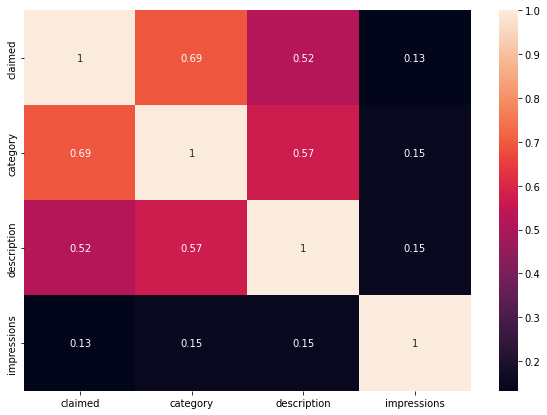

In [ ]:
plt.figure(figsize=(10,7))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

Hold-out validation is used because of the size of the dataset

In [ ]:
# Split the data into X & y

X = df[columns_to_keep].values
X

y = df['impressions']
y = y.astype(int)
y

print(X.shape)
print(y.shape)

(643166, 3)
(643166,)


In [ ]:
# Hold-out validation

# first one
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size=0.3, random_state=15)

# Second one
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size = 0.8, test_size=0.2, random_state=15)

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(360172, 3)
(192950, 3)
(90044, 3)
(360172,)
(192950,)
(90044,)


In [ ]:
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
print(class_weights)

[0.67975963 1.89074607]


In [ ]:
LogReg = LogisticRegression(random_state=0, max_iter=1000, class_weight=class_weights).fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:705: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":


In [ ]:
print("Prediction accuracy ", round(LogReg.score(X_test, y_test) * 100, 2),"%")

Prediction accuracy  73.41 %


**Adjusting the decision boundary**

Different probabilty thresholds are tried (default p=0.5) to understand whether we can optimise the F1-Score. 


In [ ]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype("int")

In [ ]:
def get_best_parameters(LogReg, X_test):

    # define thresholds
    thresholds = np.arange(0, 1, 0.001)
    pos_probs = LogReg.predict_proba(X_test)[:, 1]

    # evaluate each threshold
    scores = [f1_score(y_test, to_labels(pos_probs, t)) for t in thresholds]

    # get best threshold
    ix = np.argmax(scores)
    print("Threshold=%.3f, F-Score=%.5f" % (thresholds[ix], scores[ix]))
    
    return np.where(pos_probs > thresholds[ix], 1, 0)

In [ ]:
y_pred_new = get_best_parameters(LogReg, X_test)

Threshold=0.223, F-Score=0.45050


# Evaluating the Model

Accuracy and classification report

In [ ]:
# Accuracy on Train
print("The Training Accuracy is: ", LogReg.score(X_train, y_train))


# Accuracy on Test
print("The Testing Accuracy is: ", LogReg.score(X_test, y_test))

# Classification Report
print(classification_report(y_test, y_pred_new))

The Training Accuracy is:  0.7355541241406883
The Testing Accuracy is:  0.7341383778180876
              precision    recall  f1-score   support

           0       0.83      0.40      0.54    141652
           1       0.32      0.77      0.45     51298

    accuracy                           0.50    192950
   macro avg       0.57      0.59      0.49    192950
weighted avg       0.69      0.50      0.51    192950



Confusion matrix

In [ ]:
confusion_matrix(y_test, y_pred_new)

array([[56212, 85440],
       [11543, 39755]])

In [ ]:
#print(f"F1 score {round(f1_score(y_test, y_pred_new), 4)}")

In [ ]:
# Methods we can use in Logistic

# predict - Predict class labels for samples in X
LogReg.predict(X_train)
y_pred = LogReg.predict(X_train)

# predict_proba - Probability estimates
pred_proba = LogReg.predict_proba(X_train)

# coef_ - Coefficient of the features in the decision function
LogReg.coef_

# score- Returns the mean accuracy on the given test data and labels - below

array([[0.42385415, 0.36970502, 0.16391897]])

In [ ]:
# Confusion Matrix function

def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, cmap="YlGnBu", xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

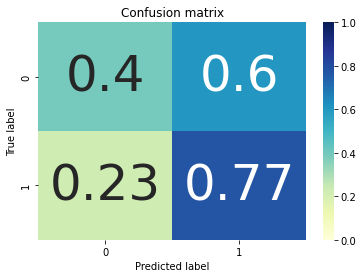

In [ ]:
# Visualizing cm

cm = confusion_matrix(y_test, y_pred_new)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

plot_confusion_matrix(cm_norm, classes = LogReg.classes_, title='Confusion matrix')

In [ ]:
# Calculating False Positives (FP), False Negatives (FN), True Positives (TP) & True Negatives (TN)

FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP + FN)
print("The True Positive Rate is:", TPR)

# Precision or positive predictive value
PPV = TP / (TP + FP)
print("The Precision is:", PPV)

# False positive rate or False alarm rate
FPR = FP / (FP + TN)
print("The False positive rate is:", FPR)

# False negative rate or Miss Rate
FNR = FN / (FN + TP)
print("The False Negative Rate is: ", FNR)

##Total averages :
print("")
print("The average TPR is:", TPR.sum()/2)
print("The average Precision is:", PPV.sum()/2)
print("The average False positive rate is:", FPR.sum()/2)
print("The average False Negative Rate is:", FNR.sum()/2)

The True Positive Rate is: [0.39683167 0.77498148]
The Precision is: [0.82963619 0.31754463]
The False positive rate is: [0.22501852 0.60316833]
The False Negative Rate is:  [0.60316833 0.22501852]

The average TPR is: 0.585906576372174
The average Precision is: 0.5735904097938704
The average False positive rate is: 0.4140934236278259
The average False Negative Rate is: 0.4140934236278259


Log loss and log odds

In [ ]:
# Running Log loss on training
print("The Log Loss on Training is: ", log_loss(y_train, pred_proba))

# Running Log loss on testing
pred_proba_t = LogReg.predict_proba(X_test)
print("The Log Loss on Testing Dataset is: ", log_loss(y_test, pred_proba_t))

The Log Loss on Training is:  0.5628154863499796
The Log Loss on Testing Dataset is:  0.5639848398818641


In [ ]:
log_odds = LogReg.coef_
odds = np.exp(log_odds)

print(odds)

[[1.52783875 1.44730762 1.17811884]]


In [ ]:
def logit2prob(LogReg, X):
  log_odds = LogReg.coef_ * X + LogReg.intercept_
  odds = np.exp(log_odds)
  probability = odds / (1 + odds)
  return(probability)

print(logit2prob(LogReg, X.astype(np.float64)))

[[0.2324594  0.22293826 0.18932364]
 [0.2324594  0.16543532 0.16543532]
 [0.2324594  0.22293826 0.18932364]
 ...
 [0.16543532 0.16543532 0.18932364]
 [0.16543532 0.16543532 0.18932364]
 [0.16543532 0.16543532 0.16543532]]


In [ ]:
import numpy
from sklearn import linear_model

X = numpy.array([3.78, 2.44, 2.09, 0.14, 1.72, 1.65, 4.92, 4.37, 4.96, 4.52, 3.69, 5.88]).reshape(-1,1)
y = numpy.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

logr = linear_model.LogisticRegression()
logr.fit(X,y)

def logit2prob(logr, X):
  log_odds = logr.coef_ * X + logr.intercept_
  odds = numpy.exp(log_odds)
  probability = odds / (1 + odds)
  return(probability)

print(logit2prob(logr, X))

The probability that a CPP has a **description** and and received impressions is **60%**

The probability that a CPP has a **category** and and received impressions is **59%**

The probability that a CPP **is claimed** and and received impressions is **54%**



